# 224x224 Retina Fotoğraflarından Diyabetik Retinopati Tespiti ve Sınıflandırma projesi

# Diabetic Retinopathy Detection and Classification Project from 224x224 Retinal Photos

*İsmail DUMLU 240711003* \
*M. Mirza ERDEM 240711012* \
*M Selçuk İNCİ 240711020*

In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-2019-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'diabetic-retinopathy-224x224-2019-data' dataset.
Path to dataset files: /kaggle/input/diabetic-retinopathy-224x224-2019-data


In [22]:
!ls -l {path}

total 56
drwxr-sr-x 7 1000 1000     0 Dec 17 21:31 colored_images
-rw-r--r-- 1 1000 1000 54948 Dec 17 21:31 train.csv


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv("/kaggle/input/diabetic-retinopathy-224x224-2019-data/train.csv")

df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [25]:
import cv2

In [26]:
def crop_image_from_gray(img,tol=7):
  if img.ndim ==2:
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]
  elif img.ndim==3:
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray_img>tol
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0):
      return img
    else:
      img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
      img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
      img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
      img = np.stack([img1,img2,img3],axis=-1)
    return img

def preprocess_image(image, sigmaX=10):
  image = np.array(image, dtype=np.uint8)
  image = crop_image_from_gray(image)
  image = cv2.resize(image, (224, 224))
  weighted = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
  return weighted.astype(np.float32) # Ensure output is float32

In [27]:
from sklearn.model_selection import train_test_split
x = df['id_code']
y = df['diagnosis']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42, stratify=y)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [29]:
!ls -l {data_dir}

total 0
drwxr-sr-x 2 1000 1000 0 Dec 17 21:31 Mild
drwxr-sr-x 2 1000 1000 0 Dec 17 21:31 Moderate
drwxr-sr-x 2 1000 1000 0 Dec 17 21:31 No_DR
drwxr-sr-x 2 1000 1000 0 Dec 17 21:31 Proliferate_DR
drwxr-sr-x 2 1000 1000 0 Dec 17 21:31 Severe


In [30]:
diagnosis_map = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR'
}
print(diagnosis_map)

{0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}


In [31]:
image_size = (300,300)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=None, # Explicitly set to None
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],
    preprocessing_function=preprocess_image

)

validation_datagen = ImageDataGenerator(
    rescale=None, # Explicitly set to None
    preprocessing_function=preprocess_image
    )

In [32]:
train_df = pd.DataFrame({'id_code': x_train, 'diagnosis': y_train})
val_df = pd.DataFrame({'id_code': x_test, 'diagnosis': y_test})

train_df['folder_name'] = train_df['diagnosis'].map(diagnosis_map)
val_df['folder_name'] = val_df['diagnosis'].map(diagnosis_map)

# 'diagnosis' sütununu string'e dönüştürme satırlarını kaldırıyoruz, böylece integer kalır.
# train_df['diagnosis'] = train_df['diagnosis'].astype(str)
# val_df['diagnosis'] = val_df['diagnosis'].astype(str)

train_df['id_code'] = train_df['folder_name'] + '/' + train_df['id_code'] + '.png'
val_df['id_code'] = val_df['folder_name'] + '/' + val_df['id_code'] + '.png'

display(train_df.head())
display(val_df.head())

,id_code,diagnosis,folder_name
2579,No_DR/b2b79b37d314.png,0,No_DR
309,Moderate/175dd560810a.png,2,Moderate
2826,Severe/c3cd0200df79.png,3,Severe
2989,No_DR/cfed7c1172ec.png,0,No_DR
3344,Moderate/e811f39a1243.png,2,Moderate


,id_code,diagnosis,folder_name
1595,No_DR/6fe67fd7f5d1.png,0,No_DR
3449,No_DR/ef8c39eb9157.png,0,No_DR
1394,Proliferate_DR/61bbc11fe503.png,4,Proliferate_DR
1379,No_DR/60edda7b4871.png,0,No_DR
3043,No_DR/d30d079e6f9a.png,0,No_DR


In [33]:
data_dir = path + '/colored_images'
img_size = image_size[0]

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='raw' # 'categorical' yerine 'raw' kullanıyoruz
)

validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    directory=data_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='raw' # 'categorical' yerine 'raw' kullanıyoruz
)

class_names = list(diagnosis_map.values())
print("Classes:", class_names)

Found 2929 validated image filenames.
Found 733 validated image filenames.
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


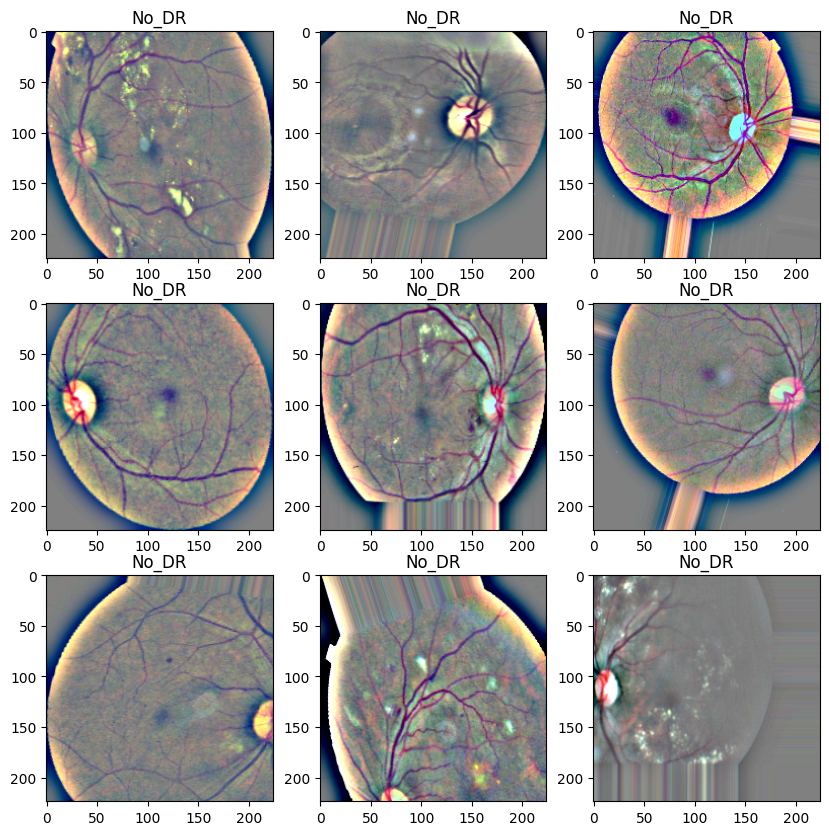

In [34]:
images, labels = next(train_generator)


plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    label_index = np.argmax(labels[i]) # Düzeltilen kısım: one-hot encoded etiketten indeksi al
    plt.title(class_names[label_index])

    plt.imshow(images[i]/255)


plt.show()

In [35]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

In [36]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)

)

In [37]:
from sklearn.utils import class_weight
import numpy as np

# 1. Ağırlıkları Hesapla
# 'balanced' modu, az olan sınıfa otomatik olarak yüksek puan verir.
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train), # Sınıfları bul (0, 1, 2, 3, 4)
    y=y_train                   # Eğitim verisindeki dağılıma bak
)

# 2. Sözlük Formatına Çevir (Keras bu formatı ister)
class_weights = dict(enumerate(weights))

# Kontrol için ekrana yazdır
print("Hesaplanan Sınıf Ağırlıkları:", class_weights)

Hesaplanan Sınıf Ağırlıkları: {0: np.float64(0.4056786703601108), 1: np.float64(1.979054054054054), 2: np.float64(0.7331664580725907), 3: np.float64(3.803896103896104), 4: np.float64(2.4822033898305085)}


In [38]:
# Ustanın (EfficientNet) bilgilerini kilitliyoruz
base_model.trainable = False

# Kendi katmanlarını ekle (Çırak)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# ==========================================
# 2. ADIM: ISINMA TURU (WARM-UP)
# Sadece senin eklediğin katmanlar hızlıca eğitilir
# ==========================================
print("\n--- 1. AŞAMA: ISINMA TURU BAŞLIYOR (Sadece son katmanlar) ---")

model.compile(
    optimizer=Adam(learning_rate=0.0001), # Yüksek hız
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Kısa bir eğitim (3-5 Epoch yeterli)
history_warmup = model.fit(
    train_generator,
    epochs=4,
    validation_data=validation_generator,
    class_weight=class_weights, # Sınıf ağırlıkları
    verbose=1
)

# Removed AUC from here, as it was causing an InvalidArgumentError when combined with class_weights and sparse labels.

# ==========================================
# 3. ADIM: İNCE AYAR (FINE-TUNING)
# Kilidi açıp tüm modeli yavaşça eğitiyoruz
# ==========================================
print("\n--- 2. AŞAMA: İNCE AYAR BAŞLIYOR (Tüm Model) ---")

base_model.trainable = True # Kilidi açtık!

# Modeli TEKRAR derliyoruz (Önemli!). Hızı çok düşürüyoruz.
model.compile(
    optimizer=Adam(learning_rate=0.00001), # Çok düşük hız (1e-5)
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] # AUC metriği kaldırıldı
)

# Callbacks tanımları (2. aşama için kritik)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_diabetic_model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

# Asıl uzun eğitim
history_finetune = model.fit(
    train_generator,
    epochs=15, # Burayı istersen 20 yapabilirsin
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights, # Sınıf ağırlıkları
    verbose=1
)


--- 1. AŞAMA: ISINMA TURU BAŞLIYOR (Sadece son katmanlar) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.3917 - loss: 1.6133 - val_accuracy: 0.6317 - val_loss: 1.0468
Epoch 2/4
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5731 - loss: 1.3529 - val_accuracy: 0.5989 - val_loss: 0.9945
Epoch 3/4
92/92 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.5974 - loss: 1.2296 - val_accuracy: 0.6139 - val_loss: 0.9351
Epoch 4/4
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6183 - loss: 1.1815 - val_accuracy: 0.6535 - val_loss: 0.8691

--- 2. AŞAMA: İNCE AYAR BAŞLIYOR (Tüm Model) ---
Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4547 - loss: 1.4708

92/92 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.4549 - loss: 1.4707 - val_accuracy: 0.6139 - val_loss: 0.9240 - learning_rate: 1.0000e-05
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5380 - loss: 1.3313 - val_accuracy: 0.6016 - val_loss: 0.9252 - learning_rate: 1.0000e-05
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.5595 - loss: 1.3600

92/92 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.5596 - loss: 1.3596 - val_accuracy: 0.6139 - val_loss: 0.9076 - learning_rate: 1.0000e-05
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.5822 - loss: 1.2833

92/92 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5823 - loss: 1.2830 - val_accuracy: 0.6235 - val_loss: 0.8848 - learning_rate: 1.0000e-05
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.5849 - loss: 1.2758

92/92 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5851 - loss: 1.2754 - val_accuracy: 0.6235 - val_loss: 0.8650 - learning_rate: 1.0000e-05
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.6162 - loss: 1.1930

92/92 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.6163 - loss: 1.1928 - val_accuracy: 0.6344 - val_loss: 0.8426 - learning_rate: 1.0000e-05
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.6185 - loss: 1.1537

92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6184 - loss: 1.1538 - val_accuracy: 0.6371 - val_loss: 0.8240 - learning_rate: 1.0000e-05
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.6177 - loss: 1.1503

92/92 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6178 - loss: 1.1500 - val_accuracy: 0.6385 - val_loss: 0.8117 - learning_rate: 1.0000e-05
Epoch 9/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.6300 - loss: 1.1777

92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.6300 - loss: 1.1770 - val_accuracy: 0.6467 - val_loss: 0.7981 - learning_rate: 1.0000e-05
Epoch 10/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.6557 - loss: 1.0180

92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6556 - loss: 1.0185 - val_accuracy: 0.6589 - val_loss: 0.7825 - learning_rate: 1.0000e-05
Epoch 11/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.6683 - loss: 1.0765

92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6683 - loss: 1.0762 - val_accuracy: 0.6617 - val_loss: 0.7712 - learning_rate: 1.0000e-05
Epoch 12/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.6520 - loss: 1.0831

92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.6521 - loss: 1.0829 - val_accuracy: 0.6712 - val_loss: 0.7624 - learning_rate: 1.0000e-05
Epoch 13/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.6593 - loss: 1.0621

92/92 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6594 - loss: 1.0618 - val_accuracy: 0.6698 - val_loss: 0.7553 - learning_rate: 1.0000e-05
Epoch 14/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.6713 - loss: 1.0127

92/92 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6714 - loss: 1.0124 - val_accuracy: 0.6739 - val_loss: 0.7478 - learning_rate: 1.0000e-05
Epoch 15/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.6675 - loss: 0.9977

92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.6676 - loss: 0.9976 - val_accuracy: 0.6767 - val_loss: 0.7456 - learning_rate: 1.0000e-05


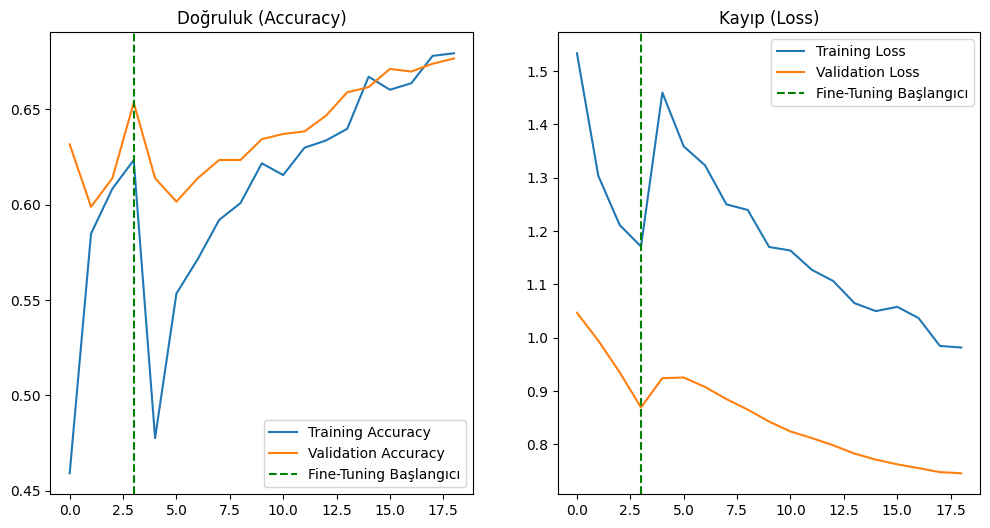

In [40]:
# ==========================================
# 4. ADIM: SONUÇLARI BİRLEŞTİRME VE ÇİZME
# ==========================================
# İki aşamanın grafik verilerini birleştiriyoruz ki tek grafikte görelim
acc = history_warmup.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_warmup.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_warmup.history['loss'] + history_finetune.history['loss']
val_loss = history_warmup.history['val_loss'] + history_finetune.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Geçiş noktasını çizgiyle gösterelim
plt.axvline(x=3, color='g', linestyle='--', label='Fine-Tuning Başlangıcı')
plt.title('Doğruluk (Accuracy)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=3, color='g', linestyle='--', label='Fine-Tuning Başlangıcı')
plt.title('Kayıp (Loss)')
plt.legend()
plt.show()